# Readme
## What are we building?
Building a natural language processing model to handle Sentiment Analysis on Foody reviews. The data is contain files for predicting the rating on Foody based on people's reviews. We need to classify each reviews into 2 class of Rating: 1(Positive) and 0(Negative).
## Architecture
<p align="center">
    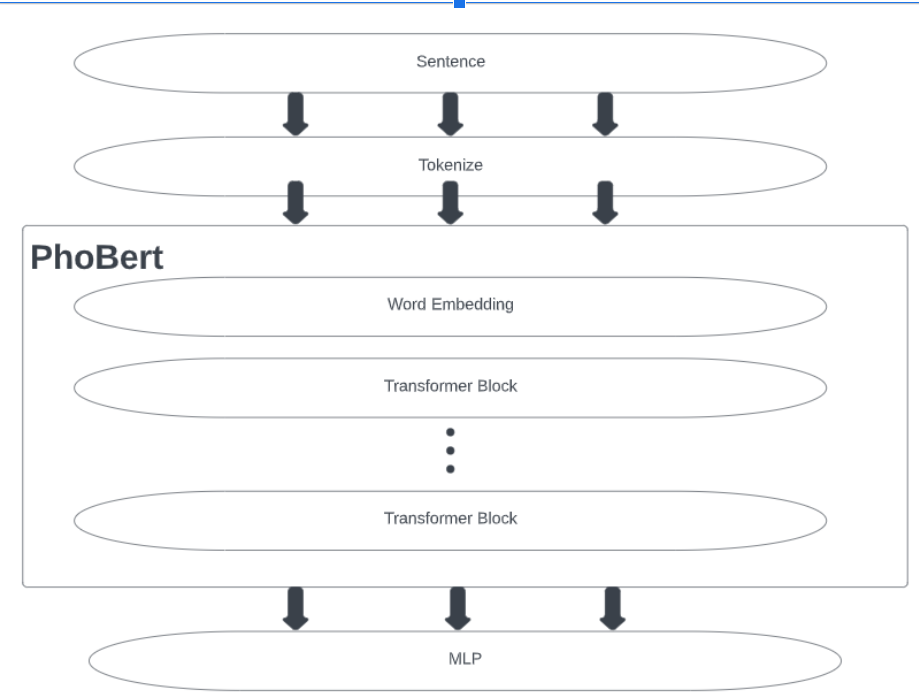
</p>

### Tokenize
- Using pretrained language models for Vietnamese: PhoBert-base. <br/>
- Phobert-base has been pre trained on 20GB of Vietnamese text <br/>
- With Phobert's tokenizer, Input is a sentence, Output is a vector of word index and a vector describes attention mask

### Phobert Prerained model
- PhoBERT pre-training approach is based on RoBERTa which optimizes the BERT pre-training procedure for more robust performance. <br/>
- It uses the same architecture of BERT-base: <br/>
- 12 layers of transformers block with a hidden size of 768 and number of self-attention heads as 12 and has around 135M trainable parameters.

### Classifier
For the classifier, we use: <br/>
- Two layers with the number of hidden units 768 <br/>
- One layer with sigmoid as activation function.

## Setup
1. Create virtual environment:<br/>
python -m venv env <br/>
2. Activate virtual environment
 - On Windows:<br/>
./env/Scripts/activate <br/>
 - On Linux:<br/>
./env/bin/activate<br/>

3. Install requirements<br/>
  pip install -r requirements.txt<br/>
4. Start Training <br/>
  Just run all cell :D Gud Luck!

------------------------------------------------------------------------------------------

# Requirements.txt
vncorenlp==1.0.3 <br/>
torch==1.11.0<br/>
pandas==1.3.5<br/>
numpy==1.21.6<br/>
seaborn==0.11.2<br/>
matplotlib==3.5.3<br/>
underthesea==1.4.0<br/>
transformers==4.20.1<br/>
scikit-learn==1.0.2<br/>
emoji==2.1.0<br/>

----------------------------------------

## Install Lib

In [ ]:
!git clone https://github.com/vncorenlp/VnCoreNLP
!pip install vncorenlp
!pip install transformers
!pip install emoji
!pip install underthesea

## Import Lib

In [ ]:
import re
import torch
import os
import gc
from vncorenlp import VnCoreNLP
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from underthesea import pos_tag
from underthesea import word_tokenize
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from transformers import AdamW, get_linear_schedule_with_warmup, get_constant_schedule
from sklearn import model_selection
from sklearn.metrics import roc_auc_score, roc_curve
import codecs
import emoji
# Batch size: 16, 32
# Learning rate (Adam): 5e-5, 3e-5, 2e-5
# Number of epochs: 2, 3, 4
N_EPOCHS = 4
BATCH_SIZE = 15
LR = 1e-5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## Load Data

In [ ]:
df = pd.read_csv('/kaggle/input/sentiment-analysis-foody/full_train_1.csv', dtype = {'UserId': str})
df.drop(['image_urls', 'Unnamed: 0'], axis = 1, inplace = True)
df.dropna(inplace = True)
df.drop_duplicates(subset=['Comment'], inplace=True)
df.head()

In [ ]:
df.info()

## EDA

In [ ]:
df['RevId'].nunique()

In [ ]:
df['Rating'].value_counts()

## Feature Engineering

### Emoj, accent handle

In [ ]:
def extract_emoji(x):
  return ''.join(c for c in x if c in emoji.EMOJI_DATA)

def check_trash_emoji(str, list):
  return 1 not in [c in str for c in list]

def creat_emoji_list():
  list_emo = []
  for c in df['Comment']:
    e = extract_emoji(c)
    if len(e) > 0:
      for x in e:
        list_emo.append(x)
  list_emo = [*set(list_emo)]
  return list_emo

In [ ]:
emo = creat_emoji_list()
trash_emo = []
good_emo = ['face', 'heart', 'thumb', 'finger', 'hand','cat','1st','star','up','hundred','NO']
for e in emo:
  if check_trash_emoji(emoji.demojize(e), good_emo):
    trash_emo.append(e)

# for e in emo:
#   if 'hand' in emoji.demojize(e):
#     print(e)

# for x in emo:
#   if x not in trash_emo:
#     print(x)

# print(trash_emo)
# print(len(trash_emo))
#print(emoji.demojize('👈'))

In [ ]:
puncts = ['"', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '#', '*', '+', '\\', '•',  '~', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›', '←', '×', '§', '″', '′', '█', '½', '…', 
 '“', '★', '”', '–', '●', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', '¯', '♦', '¤', '▲', '¸', '¾', '⋅', '‘', '∞', 
 '∙', '↓', '、', '│', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', 'ï', 'Ø', '¹', '≤', '‡', '√']

puncts = puncts + emo
#print(puncts)
s1 = u'ÀÁÂÃÈÉÊÌÍÒÓÔÕÙÚÝàáâãèéêìíòóôõùúýĂăĐđĨĩŨũƠơƯưẠạẢảẤấẦầẨẩẪẫẬậẮắẰằẲẳẴẵẶặẸẹẺẻẼẽẾếỀềỂểỄễỆệỈỉỊịỌọỎỏỐốỒồỔổỖỗỘộỚớỜờỞởỠỡỢợỤụỦủỨứỪừỬửỮữỰựỲỳỴỵỶỷỸỹ'

def check_spell(string):
  # print(string)F#
  for c in string :
    if c in s1:
      return True
  return False

def clean_punct(x):
    x = str(x)
    for punct in puncts:
        if punct in x:
            x = x.replace(punct, f' {punct} ')
    return x

def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]{4}', '####', x)
        x = re.sub('[0-9]{3}', '###', x)
        x = re.sub('[0-9]{2}', '##', x)
    return x

def remove_1_length_word(x):
    list = []
    meaningful_word = ['k', 'l', 'c', 'đ', 'ú', 'ụ'] 
    for i in x:
         if len(i)> 1 or (emoji.is_emoji(i) and i not in trash_emo) or (i in meaningful_word):
            list.append(i)
    return list

In [ ]:
df["check_accent"] = df["Comment"].apply(check_spell)
# check_vnese = pd.DataFrame()
# check_vnese = df[df["check_accent"] == False]
# check_vnese.to_excel('./check_vnese.xlsx')
df = df[df["check_accent"] == True]
df.drop(["check_accent"], axis = 1, inplace = True)
df.head()

In [ ]:

df["Comment"] = df["Comment"].apply(clean_punct)
# df["Comment"] = df["Comment"].apply(clean_numbers)
df["Comment"] = df["Comment"].apply(lambda x: [i.lower() for i in x.split(" ")])
df["Comment"] = df["Comment"].apply(lambda x: " ".join(remove_1_length_word(x)))
df.to_excel('check.xlsx')
df


### Stopwords

In [ ]:
def create_stopwordlist():
    f = codecs.open('/kaggle/input/sentiment-analysis-foody/vietnamese-stopwords.txt', encoding='utf-8')
    data = []
    for i, line in enumerate(f):
        line = repr(line)
        line = line[1:len(line)-3]
        data.append(line)
    return data

stopword_vn = create_stopwordlist()
#stopword_vn

In [ ]:
def remove_stopwords(x):
  results = []
  tmp = x.split(' ')
  for stop_word in stopword_vn:
    if stop_word in tmp:
      tmp.remove(stop_word)
  results.append(" ".join(tmp))

  s = ''
  s = s.join(results)  
  return s

In [ ]:
df["Comment"] = df["Comment"].apply(remove_stopwords)

## Split data 

In [ ]:
train_df, val_df = model_selection.train_test_split(df, test_size=0.1, random_state=42, stratify=df['Rating'])
del df
gc.collect()
train_df.reset_index(inplace=True)
val_df.reset_index(inplace=True)

In [ ]:
# pos_df = train_df[train_df['Rating'] == 1.0]
# neg_df = train_df[train_df['Rating'] == 0.0]
# # shuffle pos_df, neg_df
# pos_df = pos_df.sample(frac=1).reset_index(drop=True)
# neg_df = neg_df.sample(frac=1).reset_index(drop=True)
# rate = len(neg_df) / len(train_df)
# number_of_neg_each_batch = int(BATCH_SIZE * rate) + 1
# number_of_pos_each_batch = BATCH_SIZE - number_of_neg_each_batch
# df = pd.DataFrame()
# j = 0
# count = 0
# for i in range(0, len(pos_df), number_of_pos_each_batch):
#     total_len = 0
#     df = pd.concat([df, pos_df[i:min(i+number_of_pos_each_batch, len(pos_df))]])
#     if j!=len(neg_df):
#         df = pd.concat([df, neg_df[j:min(len(neg_df),j+number_of_neg_each_batch)]])
#     total_len += len(neg_df[j:min(len(neg_df),j+number_of_neg_each_batch)])
#     count += total_len
#     j = min(j + number_of_neg_each_batch, len(neg_df))
# df.reset_index(drop=True, inplace=True)

## Install phobert

### Install

In [ ]:
# py_vncorenlp.download_model(save_dir='/kaggle/working/')
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
rdrsegmenter = VnCoreNLP('/kaggle/working/VnCoreNLP/VnCoreNLP-1.1.1.jar', annotators="wseg", max_heap_size = '-Xmx500m')

## Dataset Architecture

In [ ]:
class SentimentDataset(Dataset):
  def __init__(self, data_df: pd.DataFrame(), max_len = 256, transform=None):
    df = data_df
    self.n_samples = df.shape[0]
    self.X = df['Comment']
    self.Y = df['Rating']
    self.Id = df['RevId']
  def __getitem__(self, index):
    sample = self.X[index], self.Y[index], self.Id[index]
    return sample
  def __len__(self):
    return self.n_samples

In [ ]:
prior = {
      1: ['A', 'Ab', 'I'],
      2: ['C', 'Cc', 'R'],
      3: ['L', 'M'],
      4: ['V', 'Vb', 'Vy'],
      5: ['X'],
      6: ['N', 'Nb', 'Nc', 'Ne'],
      7: ['Z'],
      8: ['E'],
      9: ['Fw', 'FW'],
      10: ['Ni', 'Np', 'NNp', 'Ns', 'Nu', 'Ny', 'P', 'S', 'T'],
      11: ['CH'],
    }
def truncate_word(text: str):
    # print(text)
    lst_words = text.split(' ')
    # print(len(lst_words))
    lst_index = []
    for i, word in enumerate(lst_words):
      if len(word) == 1:
        continue
      if word == 'emojiiiii' or word == 'sentimenttttt':
        lst_index.append((i, 0))
        continue
      # print(pos_tag(word))
      tag = pos_tag(word)[0][1]
      # print(word, tag)
      for key in prior:
        if tag in prior[key]:
          lst_index.append((i, key))
          break
    lst_index.sort(key=lambda x: x[1])
    lst_index = lst_index[:256]
    lst_index.sort(key=lambda x: x[0])
    truncated_str = ''
    for index in lst_index:
      # print(index[0])
      truncated_str += lst_words[index[0]] + ' '
    # print(truncated_str)
    return truncated_str[:-1]
    


In [ ]:
super_pos_emoj = ['🤑','💯','🥰','🤩','💓','❤','💚','💗','💘','♥','💖','💙','💕','😍','💜','🧡','😘','💝','😂','😝',]
pos_emoji = ['🙃','😄','👐','😁','👌','🤤','🤭','😛','😱','😋','☝','😎','🤪','😮','😹','😊','😲','😽','😇','👏','💁','😀','🖐','😸','🙋','🤗','❣','👋','😻','😆','💛','😬','🙌','🤙','😙',
'🥵','👍','😉','😗','✋','🤞','✌','😚','🥳','🍮','🤲','🖤','🙀','😃','😜','🙅','🤓','💞','😿','⭐','🥇','☺']
neutral_emoji = ['🌞','😪','🧁','🍵','😵','🧐', '👉','🐮','🐷','😨','🔺','👈','🤝','👫','😅','🤔','🤨','🌟','👆','🔯','🌚','😳','🙄','😴','😶']
neg_emoji = ['😌','😢','😭','😕', '😯','🖕','🤦','🤥','😖','🙂','🥴','😥','😑','😷','🌝','🤧','😞','😔','😫','💔','😟','😧','😏','😠','🙏','👎','🙁','😩','😰','🥺','☹','😤','🥶','😦','😓','🤡','😣','😐']
super_neg_emoj = ['😒','🤢','🤮','🤬','😡',]
map_sentiment_w = {
    ':(': "tệ",
    ':)': "ngon",
    ':v': "ngon",
    '@@': "tệ"
}

def texts_to_features(lst_text: list):
  cleaned_lst_text = []
  for text in lst_text:
    # print(text)
    # get all emoji
    lst_emoji = re.findall(r'[\U00010000-\U0010ffff]', text)
    lst_opinion = []
    for emoj in lst_emoji:
      if emoj in super_pos_emoj:
        lst_opinion.append('rất ngon')
      elif emoj in pos_emoji:
        lst_opinion.append('ngon')
      elif emoj in neg_emoji:
        lst_opinion.append('tệ')
      elif emoj in super_neg_emoj:
        lst_opinion.append('rất tệ')
      else:
        lst_opinion.append('bình thường')
    # print(lst_emoji)
    # get all sentiment word like :))) :(( :v :(((
    lst_sentiment = re.findall(r'[:;=xX8B][-oO]?[)D\]\(\[pP/\\]', text)
    # print(lst_sentiment)
    # replace emoj by 'emojiiiii'
    text = re.sub(r'[\U00010000-\U0010ffff]', 'emojiiiii ', text)
    # replace sentiment word with 'sentimenttttt'
    text = re.sub(r'[:;=xX8B][-oO]?[)D\]\(\[pP/\\]', 'sentimenttttt ', text)
    # print(text)
    sentences = rdrsegmenter.tokenize(text)
    output = []
    for sen in sentences:
        output.append(' '.join(sen))
#     print(output)
    cleaned_text = ''
    for s in output:
        tmp = re.sub(r'[^\w\s]', ' ', s)
        cleaned_text += ' ' + tmp
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    # print(cleaned_text)
    if(len(cleaned_text.split(' ')) > 256):
      cleaned_text = truncate_word(cleaned_text)
    # replace 'sentimenttttt' with coresponding sentiment word
    for i in range(len(lst_sentiment)):
        cleaned_text = cleaned_text.replace('sentimenttttt', lst_sentiment[i], 1)
    # replace 'emojiiiii' with coresponding emoji
    for i in range(len(lst_emoji)):
        cleaned_text = cleaned_text.replace('emojiiiii', lst_opinion[i], 1)
    # print(cleaned_text)
    # print('------------------------')
    cleaned_lst_text.append(cleaned_text)

  tmp_dict = tokenizer(cleaned_lst_text, padding=True, truncation=True, max_length=256)
  return torch.tensor(tmp_dict['input_ids']), torch.tensor(tmp_dict['attention_mask'])



## Model

In [ ]:
class Sentiment_Analysis(nn.Module):
  def __init__(self):
    super(Sentiment_Analysis, self).__init__()
    self.bert = AutoModel.from_pretrained("vinai/phobert-base")
    self.linear = nn.Linear(in_features=768, out_features = 768)
    self.relu = nn.ReLU()
    self.drop = nn.Dropout(0.1)
    self.norm = nn.LayerNorm(768)
    self.linear1 = nn.Linear(in_features=768, out_features = 768)
    self.drop1 = nn.Dropout(0.075)
    self.norm1 = nn.LayerNorm(768)
    self.linear2 = nn.Linear(in_features=768, out_features = 1)
    self.sigmoid = nn.Sigmoid()
#     self.tanh = nn.Tanh()
    # self.init_weights()
    # nn.init.xavier_uniform_(self.linear.weight)
    # nn.init.xavier_uniform_(self.linear1.weight)
    # nn.init.xavier_uniform_(self.linear2.weight)
  def forward(self, input_ids, attention_mask):
    X = self.bert(input_ids=input_ids,attention_mask=attention_mask)
    X = X[1]
    X = self.linear(X)
    X = self.relu(X)
    X = self.drop(X)
    X = self.norm(X)
    X = self.linear1(X)
    X = self.relu(X)
    X = self.drop1(X)
    X = self.norm1(X)
    X = self.linear2(X)
    X = self.sigmoid(X)
    return X

## Train&Eval

### Epoch Handle

In [ ]:
def train_epoch(model, criterion, optimizer, train_loader):
  model.train()
  total_loss = 0
  total = 0
  step = 1
  for data in train_loader:
    comment, label, _ = data
    # print(label.size(0), label.size(), label.tolist())
    # break
    input_ids, attention_mask = texts_to_features(comment)
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    label = label.type(torch.FloatTensor).to(device)
    optimizer.zero_grad()
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    # print("output")
    # print(outputs)
    loss = criterion(outputs.view(-1), label)
    total_loss += loss.item()
    total += label.size(0)
    loss.backward()
    optimizer.step()
    scheduler.step()
    if step < 10 or step % 100 == 0:      
      print(f"""Total loss: {total_loss:.4f} | Total: {total} | Loss: {total_loss/step:.4f}""")
    step += 1
    del input_ids
    del attention_mask
    del label
    del loss
    gc.collect()
    torch.cuda.empty_cache()

    # break
  # print(type(losses), losses)
  print(f"""Total loss: {total_loss:.4f} | Total: {total} | Loss: {total_loss/step:.4f}""")
def inference_epoch(model, criterion, data_loader, for_submit = False):
  model.eval()
  total_loss = 0
  total = 0
  y_pred = []
  y_test = []
  RevIds = []
  step = 1
  for data in data_loader:
    comment = None
    label = None
    RevId = None
    if for_submit == True:
      comment, label, RevId = data
      RevIds.extend(RevId.tolist())
    else: 
      comment, label, _ = data
    input_ids, attention_mask = texts_to_features(comment)
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    label = label.type(torch.FloatTensor).to(device)
    with torch.no_grad():
      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      y_pred.extend(outputs.view(-1).tolist()) 
      y_test.extend(label.tolist())
      loss = criterion(outputs.view(-1), label)
      total_loss += loss.item()
      total += label.size(0)
    if step < 10 or step % 100 == 0:      
      print(f"""Total loss: {total_loss:.4f} | Total: {total} | Loss: {total_loss/step:.4f}""")
    step += 1
    del input_ids
    del attention_mask
    del label
    gc.collect()
    torch.cuda.empty_cache()
  if for_submit:
    return RevIds, y_pred
  print(len(y_test), len(y_pred))
  print(y_test, y_pred)
  print('AUC: ', roc_auc_score(y_test, y_pred))
  tpr, fpr, thresholds = roc_curve(y_test, y_pred)
  plt.plot(tpr, fpr)
  plt.show()


### Let go bruhhh

In [ ]:
# DataLoader

train_dataset = SentimentDataset(data_df = train_df)
train_loader = DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle = True)
# train_iter = iter(train_loader)

val_dataset = SentimentDataset(data_df = val_df)
val_loader = DataLoader(dataset = val_dataset, batch_size = BATCH_SIZE, shuffle = True)
# val_iter = iter(val_loader)

#Initialize
model = Sentiment_Analysis()
model.cuda()
criterion = nn.BCELoss()
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=LR, correct_bias=False)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=100, num_training_steps=int(N_EPOCHS*len(train_loader))) 
# for i in range(n_epochs):
#   print(f'======== Epoch {i} / {n_epochs} ========')
#   print('Training...')
#   train_epoch(model, optimizer, train_loader)


In [ ]:
for i in range(N_EPOCHS):
  print(f'======== Epoch {i+1} / {N_EPOCHS} ========')
  print('Training...')
  if i == 1:
    scheduler = get_constant_schedule(optimizer)
  train_epoch(model, criterion, optimizer, train_loader)
  inference_epoch(model, criterion, val_loader)
  # break


In [ ]:
# !pip list


## Submission

In [ ]:
test_df = pd.read_csv('/kaggle/input/sentiment-analysis-foody/test_translated.csv')
test_df.drop(['Unnamed: 0'], axis = 1, inplace = True)
test_df.fillna('', inplace = True)
test_df.info()

In [ ]:
test_df["Comment"] = test_df["Comment"].apply(clean_punct)
# df["Comment"] = df["Comment"].apply(clean_numbers)
test_df["Comment"] = test_df["Comment"].apply(lambda x: [i.lower() for i in x.split(" ")])
test_df["Comment"] = test_df["Comment"].apply(lambda x: " ".join(remove_1_length_word(x)))
test_df["Comment"] = test_df["Comment"].apply(remove_stopwords)
test_df['Rating'] = 0
test_df.head()


In [ ]:
test_dataset = SentimentDataset(data_df = test_df)
test_loader = DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, shuffle = True)

In [ ]:
RevIds, y_pred = inference_epoch(model, criterion, test_loader, for_submit = True)

In [ ]:
submit = pd.DataFrame(columns=['RevId', 'Rating'])
submit['RevId'] = RevIds
submit['Rating'] = y_pred
submit

In [ ]:
submit.to_csv('/content.gdrive/MyDrive/Sentiment_Analysis/submission.csv', index = False)